In [1]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI,OpenAIEmbeddings #this to above classes we used to interact with llm model.
from dotenv import load_dotenv
from langgraph.graph import StateGraph,END,START #this class we used to build stateful workflows in graphical form mei.
from pydantic import BaseModel,Field,computed_field
from typing import Annotated,List,Dict,TypedDict,Optional
from langchain_core.output_parsers import PydanticOutputParser,StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from typing import Literal,Optional
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage
import operator
from langgraph.graph.message import BaseMessage 
#above class is parent class this all AIMessage,HumanMessage,SystemMessage classes is child class inheriting property from parent
#messages will automatically get handle.


#using persistence class to store state or memory value in Ram or Database.
from langgraph.checkpoint.memory import InMemorySaver

load_dotenv()

True

# Using Persistence to store Memory State 

In [2]:
checkpointer = InMemorySaver()
checkpointer

# step:1) defining the model objects class

In [3]:
#Groq Model object
model1 = ChatGroq(
    model="groq/compound-mini",
    temperature=0.2
)
model1

#openAI model object.
model2 = ChatOpenAI(temperature=0.2)

## Hugging Face endpoint define karo OPen source Model chat or Generation Model.
llm = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct-v0.3",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
)

# Chat model object banao
model3 = ChatHuggingFace(llm=llm)

# step:2) defining sequential workflow ke liye state or memory schema using typeddict futhure we r creating object of stategraph class

In [4]:
class JokeState(TypedDict):
    title : str
    gen_joke : str | None
    gen_expl : str | None
    

In [5]:
#creating an object of stategraph class.
graph = StateGraph(JokeState)
graph

# creating workflow based on Goal

In [6]:
#creating Generate_Joke node ke liye function.
def Generate_Joke(state:JokeState) ->JokeState:
    
    parser = StrOutputParser()
    
    #fetching the topic from state class
    topic = state['title']
    
    #creating a prompt template or structure instruction based on this topic.
    prompt = PromptTemplate(
        template="""
        You are an expert joke generator.  
        Your task is to create a **funny joke** based strictly on the given topic: "{topic}".

        Instructions:
        1. Make the joke humorous, witty, and short (2-3 sentences max).  
        2. Do not add anything extra outside the joke.  
        3. The joke should be original and not copied.  
        
        """,
        input_variables=['topic']
        
    )
    
    #passing the prompt to model. using sequential chain
    chain = prompt | model1 | parser
    
    #invoking the chain.
    result = chain.invoke({'topic':topic})
    
    #now updating the state the partial stae and returning back.
    return {
        'gen_joke':result
    }
    

In [7]:
#creating Generate_Explanation node ke liye function.
def Generate_Explanation(state:JokeState) ->JokeState:
    
    parser = StrOutputParser()
    
    #fetching the topic from state class
    topic = state['title']
    joke = state['gen_joke']
    
    #creating a prompt template or structure instruction based on this topic.
    prompt = PromptTemplate(
        template="""
        You are an expert joke explanation.  
        Your task is to provide Explantion of  **funny joke** based on the given Joke topic: "{joke}".

        Instructions:
        1. Make the Explanation of Joke to be short (2-3 sentences max).  
        2. The Explanation should be original and not copied.  
        
        """,
        input_variables=['joke']
        
    )
    
    #passing the prompt to model. using sequential chain
    chain = prompt | model1 | parser
    
    #invoking the chain.
    result = chain.invoke({'joke':joke})
    
    #now updating the state the partial stae and returning back.
    return {
        'gen_expl':result
    }
    

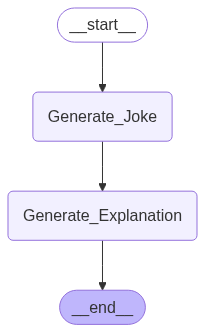

In [8]:
#adding the node to graph.
graph.add_node(node="Generate_Joke",action=Generate_Joke)
graph.add_node(node="Generate_Explanation",action=Generate_Explanation)



#adding edges to graph
graph.add_edge(START,'Generate_Joke')
graph.add_edge('Generate_Joke','Generate_Explanation')
graph.add_edge('Generate_Explanation',END)

#compiling the graph.
graph.compile()

# step:4) defining the workflow and starting the execution of workflow providing initial state

In [9]:
workflow = graph.compile(checkpointer=checkpointer)

#calling the initial state by creating an object of that class.
initial_state = JokeState(title="AI in India")


#now invoking the workflow passing the inital state throughout workflow.
result = workflow.invoke(input=initial_state,config={"configurable": {"thread_id": "1"}})
result

{'title': 'AI in India',
 'gen_joke': 'Why did India\'s AI model go to therapy? Because it was struggling to learn from its mistakes and kept predicting a "server error" in life. Now it\'s trained to respond with "naaah, chai peena hai" to every problem!',
 'gen_expl': 'The joke is funny because it personifies India\'s AI model as struggling with self-improvement, much like humans do, and its "therapy" results in a humorous cultural twist. The punchline "naaah, chai peena hai" (no, let\'s have tea) is a lighthearted, relatable response that Indians often use to deflect problems, implying the AI has learned to cope with issues in a uniquely human way. The joke blends tech and culture for comedic effect.'}

# if i want to show persistence saving the state throughout workflow or not.

In [11]:
#iska faida yeh hai if i know the thread_id based on that we can fetch the chat history
workflow.get_state(config={"configurable": {"thread_id": "1"}})

StateSnapshot(values={'title': 'AI in India', 'gen_joke': 'Why did India\'s AI model go to therapy? Because it was struggling to learn from its mistakes and kept predicting a "server error" in life. Now it\'s trained to respond with "naaah, chai peena hai" to every problem!', 'gen_expl': 'The joke is funny because it personifies India\'s AI model as struggling with self-improvement, much like humans do, and its "therapy" results in a humorous cultural twist. The punchline "naaah, chai peena hai" (no, let\'s have tea) is a lighthearted, relatable response that Indians often use to deflect problems, implying the AI has learned to cope with issues in a uniquely human way. The joke blends tech and culture for comedic effect.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08b007-f090-6dc3-8002-3a61d98e6602'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-09-06T09:04:29.604601+00:00', parent_config={'configurable': {

# to show intermediate state or start or final state value

In [12]:
# if i want to show the history of state (for paticular thread_id)
list(workflow.get_state_history(config={"configurable": {"thread_id": "1"}}))

[StateSnapshot(values={'title': 'AI in India', 'gen_joke': 'Why did India\'s AI model go to therapy? Because it was struggling to learn from its mistakes and kept predicting a "server error" in life. Now it\'s trained to respond with "naaah, chai peena hai" to every problem!', 'gen_expl': 'The joke is funny because it personifies India\'s AI model as struggling with self-improvement, much like humans do, and its "therapy" results in a humorous cultural twist. The punchline "naaah, chai peena hai" (no, let\'s have tea) is a lighthearted, relatable response that Indians often use to deflect problems, implying the AI has learned to cope with issues in a uniquely human way. The joke blends tech and culture for comedic effect.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08b007-f090-6dc3-8002-3a61d98e6602'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-09-06T09:04:29.604601+00:00', parent_config={'configurable': 

# again invoking the workflow with different thread_id

In [13]:
#now invoking the workflow passing the inital state throughout workflow.
config2 = {"configurable": {"thread_id": "2"}}
result2 = workflow.invoke(input={'title':"pasta"},config=config2)
result2

{'title': 'pasta',
 'gen_joke': 'Why did the pasta go to therapy? It was feeling a little "drained" and had a lot of "saucy" issues to work through. Now it\'s learning to "twirl" its problems away.',
 'gen_expl': 'This joke plays on the double meanings of pasta-related terms, using "drained" (emotionally exhausted), "saucy" (both a pasta characteristic and impertinent), and "twirl" (both a pasta eating action and dealing with problems in a carefree way). The punchline cleverly connects pasta actions to emotional states, creating a humorous therapeutic journey. The joke requires a basic knowledge of pasta to appreciate the wordplay.'}

In [14]:
# if i want to show the history of state (for paticular thread_id)
list(workflow.get_state_history(config=config2))

[StateSnapshot(values={'title': 'pasta', 'gen_joke': 'Why did the pasta go to therapy? It was feeling a little "drained" and had a lot of "saucy" issues to work through. Now it\'s learning to "twirl" its problems away.', 'gen_expl': 'This joke plays on the double meanings of pasta-related terms, using "drained" (emotionally exhausted), "saucy" (both a pasta characteristic and impertinent), and "twirl" (both a pasta eating action and dealing with problems in a carefree way). The punchline cleverly connects pasta actions to emotional states, creating a humorous therapeutic journey. The joke requires a basic knowledge of pasta to appreciate the wordplay.'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f08b01d-76cd-6891-8002-e0998656a9a5'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-09-06T09:14:07.394830+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f08b01d-6ff7-

``` 
advantage of persistence we are achieving few advantages: 
1) implement short term memory
2) we can overcome fault tolerance problem.
3) add Human in the Loop (to pause or resume the workflow)
4) time travel



```